# Using Deep Learning to Identify Images of Fruits

I will be using deep learning techniques via the Keras API to train a Convolutional Neural Network (CNN) model on a dataset of fruit images, and evaluate this model's accuracy on a separate test dataset of fruit images.

I will be focusing on optimizing my CNN model to give me the highest possible accuracy on both my training & test data.

## Importing Training & Test Images

In [7]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import skimage
from skimage import io, transform
from IPython.display import Image, display

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Input
from keras.models import Model
from keras.optimizers import Adam

img_size = 100
train_dir = './data/fruits/train/'
test_dir = './data/fruits/test/'

def get_data(folder_path):
    imgs = []
    indices = []
    labels = []
    for idx, folder_name in enumerate(os.listdir(folder_path)[:35]):
        if not folder_name.startswith('.'):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(folder_path + folder_name)):
                if not file_name.startswith('.'):
                    img_file = io.imread(folder_path + folder_name + '/' + file_name)
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size))
                        imgs.append(np.asarray(img_file))
                        indices.append(idx)
    imgs = np.asarray(imgs)
    indices = np.asarray(indices)
    labels = np.asarray(labels)
    return imgs, indices, labels

X_train, y_train, train_labels = get_data(train_dir)
X_test, y_test, test_labels = get_data(test_dir)

  0%|          | 0/490 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 166/166 [00:00<00:00, 357.15it/s]


## Data Wrangling

In [8]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train:', y_train)
print('y_test:', y_test)
# print('First image - X_train:', X_train[0])

num_categories = len(np.unique(y_train))

new_X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]).astype('float32')
new_X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]).astype('float32')
new_y_train = keras.utils.to_categorical(y_train, num_categories)
new_y_test = keras.utils.to_categorical(y_test, num_categories)

X_train shape: (17781, 100, 100, 3)
X_test shape: (5971, 100, 100, 3)
y_train: [ 0  0  0 ... 34 34 34]
y_test: [ 0  0  0 ... 34 34 34]


## Exploratory Data Analysis

In [9]:
def display_imgs(folder_path):
    for idx, folder_name in enumerate(os.listdir(folder_path)):
        if idx % 25 == 0:
            if not folder_name.startswith('.'):
                for idx2, file_name in enumerate(tqdm(os.listdir(folder_path + folder_name))):
                    if idx2 % 75 == 0:
                        if not file_name.startswith('.'):
                            img_filename = folder_path + folder_name + '/' + file_name
                            display(Image(filename=img_filename))

### Examples of Training Images

  0%|          | 0/490 [00:00<?, ?it/s]

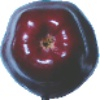

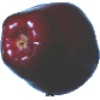

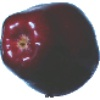

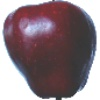

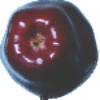

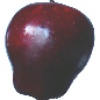

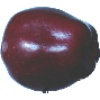

  0%|          | 0/492 [00:00<?, ?it/s]

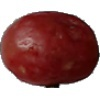

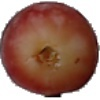

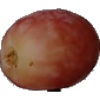

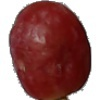

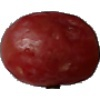

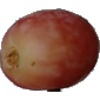

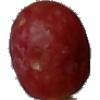

  0%|          | 0/490 [00:00<?, ?it/s]

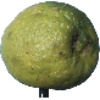

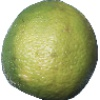

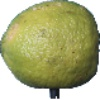

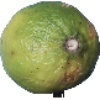

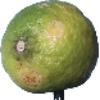

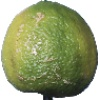

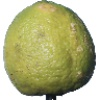

100%|██████████| 490/490 [00:00<00:00, 48333.98it/s]


In [10]:
display_imgs(train_dir)

### Examples of Test Images

  0%|          | 0/166 [00:00<?, ?it/s]

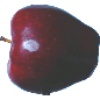

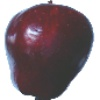

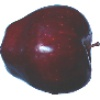

  0%|          | 0/164 [00:00<?, ?it/s]

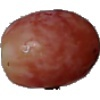

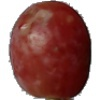

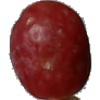

  0%|          | 0/166 [00:00<?, ?it/s]

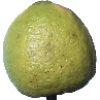

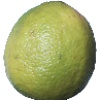

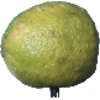

100%|██████████| 166/166 [00:00<00:00, 34591.34it/s]


In [11]:
display_imgs(test_dir)

## Initial Model Selection
### Convolutional Neural Network (CNN)

In [ ]:
def evaluate_model(model, batch_size, epochs):
    history = model.fit(new_X_train, new_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(new_X_test, new_y_test))
    score = model.evaluate(new_X_test, new_y_test, verbose=0)
    print('***Metrics Names***', model.metrics_names)
    print('***Metrics Values***', score)

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.25))

convolutional.add(Flatten())
convolutional.add(Dense(128, activation='relu'))
convolutional.add(Dropout(0.5))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 5)

From the above epochs, I can already see that my model is slightly over-fitting on my training data. Overall, my model is already performing at ~94% accuracy at its best, but is drastically overfitting. I will now be trying to optimize this model. 

## Optimizing the CNN Model
### Strategy 1 – Increase Dropout Rates to Counter Overfitting

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.6))

convolutional.add(Flatten())
convolutional.add(Dense(128, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 7)

Increasing the dropout does help with overfitting – it doesn't overfit until later in the epochs, and even then by a smaller percentage. Overall, this model has a better performance than my initial model, hovering at ~95% validation accuracy.

### Strategy 2 – Use Different Loss Functions [Not Successful]

In [ ]:
def run_with_loss(loss):
    convolutional = Sequential()

    convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
    convolutional.add(Conv2D(64, (3, 3), activation='relu'))
    convolutional.add(MaxPooling2D(pool_size=(2, 2)))
    convolutional.add(Dropout(0.6))

    convolutional.add(Flatten())
    convolutional.add(Dense(128, activation='relu'))
    convolutional.add(Dropout(0.6))
    convolutional.add(Dense(num_categories, activation='softmax'))

    convolutional.summary()
    convolutional.compile(loss=loss, optimizer=Adam(), metrics=['accuracy'])

    evaluate_model(convolutional, 128, 5)

losses = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']

for loss in losses:
    run_with_loss(loss)

None of these other loss functions show a significant improvement over the original loss function of 'categorical_crossentropy'. Of the 3 attempted, 'mean_squared_error' performed the best.

### Strategy 3 – Add More Convolutional Layers [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 128, 5)

This model is still overfitting from the 3rd epoch onwards, but I am getting a slightly better performance with best validation accuracy of ~97%.

### Strategy 4 – Decrease Batch Size [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

This is yielding roughly similar performance – validation accuracy is hovering at ~97%. 

### Strategy 5 – Decrease Kernel Size [Not Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (2, 2), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
convolutional.add(Conv2D(256, (2, 2), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

Decreasing kernel size doesn't yield any significant improvements – if anything, it causes the model to overfit earlier and to reach a slightly lower maximum validation accuracy (~85%). 

### Strategy 6 – Decrease Learning Rate [Successful]

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

Decreasing the learning rate resulted in slightly higher accuracy rates, though it did slightly increase the runtime of the model. I will be keeping this lower learning rate, as I don't believe the speed decrease was significant enough to be a detriment to the model.

## Finalizing Model

Combine all successful optimizing strategies (additional convolutional layers, increased dropout rates, decreased batch size, etc.), alongside Batch Normalization, for a final optimized model.

In [ ]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

# CHANGE
convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(BatchNormalization())
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

### Evaluating Finalized Model

In [ ]:
y_pred = convolutional.predict(new_X_test, batch_size=None, verbose=0, steps=None).argmax(axis=-1)
res_crosstab = pd.crosstab(y_pred, y_test)

dict_idx_fruit = {idx: label for idx, label in enumerate(test_labels)}
print(dict_idx_fruit)

res_crosstab

In [ ]:
for idx in range(num_categories):
    accuracy = res_crosstab.loc[idx, idx] / res_crosstab.loc[:, idx].sum()
    flag = '***LOW***' if accuracy < 0.8 else ''
    print(dict_idx_fruit[idx])
    print('   ', flag, 'accuracy –', round(accuracy * 100, 2), '%')

## Running Final Model On More Data

In [1]:
# Run on Kaggle with GPU 

import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import skimage
from skimage import io, transform
from IPython.display import Image, display

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Input
from keras.models import Model
from keras.optimizers import Adam

img_size = 100
train_dir = '../input/fruits-360_dataset/fruits-360/Training/'
test_dir = '../input/fruits-360_dataset/fruits-360/Test/'

def get_data(folder_path):
    imgs = []
    indices = []
    labels = []
    for idx, folder_name in enumerate(os.listdir(folder_path)[:35]):
        if not folder_name.startswith('.'):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(folder_path + folder_name)):
                if not file_name.startswith('.'):
                    img_file = io.imread(folder_path + folder_name + '/' + file_name)
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size))
                        imgs.append(np.asarray(img_file))
                        indices.append(idx)
    imgs = np.asarray(imgs)
    indices = np.asarray(indices)
    labels = np.asarray(labels)
    return imgs, indices, labels

X_train, y_train, train_labels = get_data(train_dir)
X_test, y_test, test_labels = get_data(test_dir)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
  0%|          | 0/492 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 164/164 [00:00<00:00, 336.49it/s]


In [2]:
num_categories = len(np.unique(y_train))

new_X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]).astype('float32')
new_X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]).astype('float32')
new_y_train = keras.utils.to_categorical(y_train, num_categories)
new_y_test = keras.utils.to_categorical(y_test, num_categories)

In [3]:
def evaluate_model(model, batch_size, epochs):
    history = model.fit(new_X_train, new_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(new_X_test, new_y_test))
    score = model.evaluate(new_X_test, new_y_test, verbose=0)
    print('***Metrics Names***', model.metrics_names)
    print('***Metrics Values***', score)

In [4]:
convolutional = Sequential()

convolutional.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)))
convolutional.add(Conv2D(64, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
convolutional.add(Conv2D(256, (3, 3), activation='relu'))
convolutional.add(MaxPooling2D(pool_size=(2, 2)))
convolutional.add(Dropout(0.35))

convolutional.add(Flatten())
convolutional.add(Dense(512, activation='relu'))
convolutional.add(Dropout(0.6))
convolutional.add(BatchNormalization())
convolutional.add(Dense(num_categories, activation='softmax'))

convolutional.summary()
convolutional.compile(loss="categorical_crossentropy", optimizer=Adam(lr=.0005), metrics=['accuracy'])

evaluate_model(convolutional, 32, 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 256)       0         
__________

In [5]:
# Save model to disk
model_json = convolutional.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
convolutional.save_weights("cnn_model.h5")
print("CNN model saved to disk")

CNN model saved to disk


In [6]:
# Load model from disk
json_file = open('cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("cnn_model.h5")
print("CNN model loaded from disk")

CNN model loaded from disk


In [7]:
y_pred = loaded_model.predict(new_X_test, batch_size=None, verbose=0, steps=None).argmax(axis=-1)
res_crosstab = pd.crosstab(y_pred, y_test)

dict_idx_fruit = {idx: label for idx, label in enumerate(test_labels)}
print(dict_idx_fruit)

res_crosstab

{0: 'Nectarine', 1: 'Kaki', 2: 'Avocado', 3: 'Apple Golden 3', 4: 'Lemon', 5: 'Pear Monster', 6: 'Apple Red Yellow', 7: 'Tomato 1', 8: 'Cherry 2', 9: 'Apple Red 1', 10: 'Pear Abate', 11: 'Mandarine', 12: 'Strawberry', 13: 'Cherry Rainier', 14: 'Cocos', 15: 'Cantaloupe 2', 16: 'Granadilla', 17: 'Pomegranate', 18: 'Lychee', 19: 'Quince', 20: 'Raspberry', 21: 'Tangelo', 22: 'Mango', 23: 'Plum', 24: 'Tamarillo', 25: 'Apple Granny Smith', 26: 'Tomato Maroon', 27: 'Passion Fruit', 28: 'Lemon Meyer', 29: 'Grapefruit White', 30: 'Banana Red', 31: 'Tomato 4', 32: 'Huckleberry', 33: 'Cherry Wax Yellow', 34: 'Physalis with Husk'}


col_0,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
row_0,,,,,,,,,,,,,,,,,,,,,
0,140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,166,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,143,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,161,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,164,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,166,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,24,0,0,0,0,0,164,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,246,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,246,0,...,0,0,0,0,0,0,0,0,0,0


## Problem Points in Model

In [8]:
for idx in range(num_categories):
    accuracy = res_crosstab.loc[idx, idx] / res_crosstab.loc[:, idx].sum()
    flag = '***LOW***' if accuracy < 0.75 else ''
    print(dict_idx_fruit[idx])
    print('   ', flag, 'accuracy –', round(accuracy * 100, 2), '%')

Nectarine
     accuracy – 85.37 %
Kaki
     accuracy – 100.0 %
Avocado
     accuracy – 100.0 %
Apple Golden 3
     accuracy – 100.0 %
Lemon
     accuracy – 100.0 %
Pear Monster
     accuracy – 100.0 %
Apple Red Yellow
     accuracy – 100.0 %
Tomato 1
     accuracy – 100.0 %
Cherry 2
     accuracy – 100.0 %
Apple Red 1
     accuracy – 100.0 %
Pear Abate
     accuracy – 94.58 %
Mandarine
     accuracy – 100.0 %
Strawberry
     accuracy – 100.0 %
Cherry Rainier
     accuracy – 100.0 %
Cocos
     accuracy – 100.0 %
Cantaloupe 2
     accuracy – 100.0 %
Granadilla
     accuracy – 100.0 %
Pomegranate
     accuracy – 100.0 %
Lychee
     accuracy – 100.0 %
Quince
     accuracy – 100.0 %
Raspberry
     accuracy – 100.0 %
Tangelo
     accuracy – 100.0 %
Mango
     accuracy – 100.0 %
Plum
     accuracy – 100.0 %
Tamarillo
     accuracy – 100.0 %
Apple Granny Smith
     accuracy – 100.0 %
Tomato Maroon
     accuracy – 100.0 %
Passion Fruit
     accuracy – 100.0 %
Lemon Meyer
     accuracy – 100.0 %

In [9]:
for idx in range(35):
    for idx2 in range(35):
        accuracy = res_crosstab.loc[idx, idx] / res_crosstab.loc[:, idx].sum()
        if idx != idx2 and res_crosstab.loc[idx, idx2] != 0:
            pred_fruit = dict_idx_fruit[idx]
            actual_fruit = dict_idx_fruit[idx2]
            num_mistakes = res_crosstab.loc[idx, idx2]
            sing_or_plural = 's' if num_mistakes > 1 else ''
            print('- {} {}{} mistaken for {}{}'.format(num_mistakes, actual_fruit, sing_or_plural, pred_fruit, sing_or_plural))

- 24 Nectarines mistaken for Apple Red Yellows
- 7 Pear Abates mistaken for Cocoss
- 2 Pear Abates mistaken for Banana Reds


## Prediction Demo with Loaded Model

  0%|          | 0/164 [00:00<?, ?it/s]

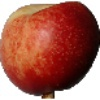

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 0/166 [00:00<?, ?it/s]

Nectarine – predicted as Apple Red Yellow INCORRECT


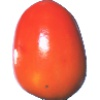

  0%|          | 0/143 [00:00<?, ?it/s]

Kaki – predicted as Kaki 


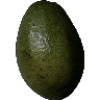

  0%|          | 0/161 [00:00<?, ?it/s]

Avocado – predicted as Avocado 


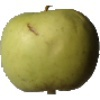

  0%|          | 0/164 [00:00<?, ?it/s]

Apple Golden 3 – predicted as Apple Golden 3 


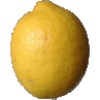

  0%|          | 0/166 [00:00<?, ?it/s]

Lemon – predicted as Lemon 


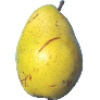

  0%|          | 0/164 [00:00<?, ?it/s]

Pear Monster – predicted as Pear Monster 


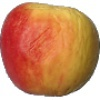

  0%|          | 0/246 [00:00<?, ?it/s]

Apple Red Yellow – predicted as Apple Red Yellow 


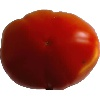

  0%|          | 0/246 [00:00<?, ?it/s]

Tomato 1 – predicted as Tomato 1 


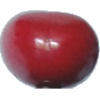

  0%|          | 0/164 [00:00<?, ?it/s]

Cherry 2 – predicted as Cherry 2 


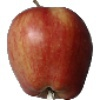

  0%|          | 0/166 [00:00<?, ?it/s]

Apple Red 1 – predicted as Apple Red 1 


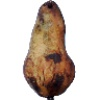

  0%|          | 0/166 [00:00<?, ?it/s]

Pear Abate – predicted as Pear Abate 


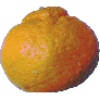

  0%|          | 0/164 [00:00<?, ?it/s]

Mandarine – predicted as Mandarine 


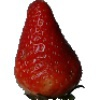

  0%|          | 0/246 [00:00<?, ?it/s]

Strawberry – predicted as Strawberry 


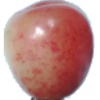

  0%|          | 0/166 [00:00<?, ?it/s]

Cherry Rainier – predicted as Cherry Rainier 


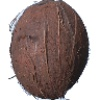

  0%|          | 0/164 [00:00<?, ?it/s]

Cocos – predicted as Cocos 


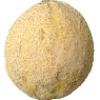

  0%|          | 0/166 [00:00<?, ?it/s]

Cantaloupe 2 – predicted as Cantaloupe 2 


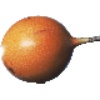

  0%|          | 0/164 [00:00<?, ?it/s]

Granadilla – predicted as Granadilla 


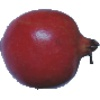

  0%|          | 0/166 [00:00<?, ?it/s]

Pomegranate – predicted as Pomegranate 


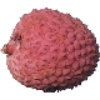

  0%|          | 0/166 [00:00<?, ?it/s]

Lychee – predicted as Lychee 


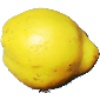

  0%|          | 0/166 [00:00<?, ?it/s]

Quince – predicted as Quince 


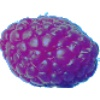

  0%|          | 0/166 [00:00<?, ?it/s]

Raspberry – predicted as Raspberry 


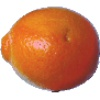

  0%|          | 0/166 [00:00<?, ?it/s]

Tangelo – predicted as Tangelo 


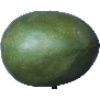

Mango – predicted as Mango 


  0%|          | 0/151 [00:00<?, ?it/s]

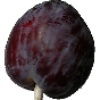

  0%|          | 0/166 [00:00<?, ?it/s]

Plum – predicted as Plum 


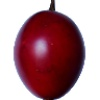

  0%|          | 0/164 [00:00<?, ?it/s]

Tamarillo – predicted as Tamarillo 


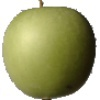

  0%|          | 0/127 [00:00<?, ?it/s]

Apple Granny Smith – predicted as Apple Granny Smith 


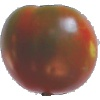

100%|██████████| 127/127 [00:00<00:00, 10235.32it/s]

Tomato Maroon – predicted as Tomato Maroon 



  0%|          | 0/166 [00:00<?, ?it/s]

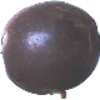

  0%|          | 0/166 [00:00<?, ?it/s]

Passion Fruit – predicted as Passion Fruit 


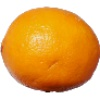

  0%|          | 0/164 [00:00<?, ?it/s]

Lemon Meyer – predicted as Lemon Meyer 


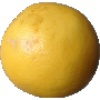

  0%|          | 0/166 [00:00<?, ?it/s]

Grapefruit White – predicted as Grapefruit White 


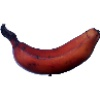

  0%|          | 0/160 [00:00<?, ?it/s]

Banana Red – predicted as Banana Red 


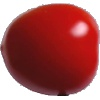

100%|██████████| 160/160 [00:00<00:00, 11343.62it/s]

Tomato 4 – predicted as Tomato 4 



  0%|          | 0/166 [00:00<?, ?it/s]

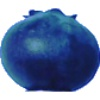

  0%|          | 0/164 [00:00<?, ?it/s]

Huckleberry – predicted as Huckleberry 


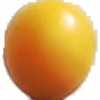

  0%|          | 0/164 [00:00<?, ?it/s]

Cherry Wax Yellow – predicted as Cherry Wax Yellow 


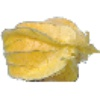

100%|██████████| 164/164 [00:00<00:00, 12880.66it/s]

Physalis with Husk – predicted as Physalis with Husk 
Nectarine – predicted as Apple Red Yellow INCORRECT
Kaki – predicted as Kaki 
Avocado – predicted as Avocado 
Apple Golden 3 – predicted as Apple Golden 3 
Lemon – predicted as Lemon 
Pear Monster – predicted as Pear Monster 
Apple Red Yellow – predicted as Apple Red Yellow 
Tomato 1 – predicted as Tomato 1 
Cherry 2 – predicted as Cherry 2 
Apple Red 1 – predicted as Apple Red 1 
Pear Abate – predicted as Pear Abate 
Mandarine – predicted as Mandarine 
Strawberry – predicted as Strawberry 
Cherry Rainier – predicted as Cherry Rainier 
Cocos – predicted as Cocos 
Cantaloupe 2 – predicted as Cantaloupe 2 
Granadilla – predicted as Granadilla 
Pomegranate – predicted as Pomegranate 
Lychee – predicted as Lychee 
Quince – predicted as Quince 
Raspberry – predicted as Raspberry 
Tangelo – predicted as Tangelo 
Mango – predicted as Mango 
Plum – predicted as Plum 
Tamarillo – predicted as Tamarillo 
Apple Granny Smith – predicted as Appl

In [10]:
def get_one_img_per_fruit(folder_path):
    printouts = []
    for idx, folder_name in enumerate(os.listdir(folder_path)[:35]):
        if not folder_name.startswith('.'):
            for idx2, file_name in enumerate(tqdm(os.listdir(folder_path + folder_name))):
                if idx2 == 0:
                    if not file_name.startswith('.'):
                        img_filename = folder_path + folder_name + '/' + file_name
                        display(Image(filename=img_filename))
                        
                        current_img = io.imread(img_filename)
                        current_img = transform.resize(current_img, (img_size, img_size))
                        current_img = np.asarray(current_img)
                        current_img = np.asarray([current_img])
                        
                        current_pred = loaded_model.predict(current_img, batch_size=None, verbose=0, steps=None).argmax(axis=-1)
                        current_pred = dict_idx_fruit[current_pred[0]]
                        
                        is_incorrect = 'INCORRECT' if folder_name != current_pred else ''
                        
                        msg = '{} – predicted as {} {}'.format(folder_name, current_pred, is_incorrect)
                        print(msg)
                        printouts.append(msg)
    return printouts
                    
printouts = get_one_img_per_fruit(test_dir)

for msg in printouts:
    print(msg)

## Conclusion

The final CNN model is performing 5% better than the initial model, with a validation accuracy of 99.4% and training accuracy of 99.9%. There is very little overfitting (0.5%) – less than in the original model.

Looking at the crosstab by category, it is obvious that most fruits are being predicted accurately, with a handful (e.g. Nectarines, Pear Abates) that are more difficult to distinguish and thus bringing the accuracy of the overall model down. In the future, we could add more images to train on pairs of fruits that are being mistaken for each other (i.e. Nectarines vs. Apple Red Yellows, Pear Abates vs. Cocos, etc.). 

I could also add TensorBoard visualizations to visualize model performance in the future, but the environment I was working with (Kaggle GPU) was the limiting factor in this realm. Unfortunately, this was already barely enough resources to run my models as is.